In [106]:
import dill as pickle
import matplotlib.pyplot as plt
import numpy as np
from model_hpc import get_data, accuracy_score
import pandas as pd

plt.style.use("seaborn")

## Data

In [30]:
 X, X_train, X_val, y, y_train, y_val = get_data()

## Adaboost

In [275]:
class AdaboostEvaluator:
    def __init__(self, file):
        self.gs = pickle.load( open(file, "rb"))

        self.max_depth = [self.gs["max_depth"][i] for i in range(len(self.gs["max_depth"])) if self.gs["boost_grid"][i] is not None]
        self.n_estimators = [self.gs["boost_grid"][i].best_estimator_.n_estimators for i in range(len(self.max_depth))]# if gs["boost_grid"][i] is not None]
        self.acc_train = [accuracy_score(y_train, self.gs["boost_grid"][i].best_estimator_.predict(X_train)) for i in range(len(self.max_depth))]
        self.acc_val = [accuracy_score(y_val, self.gs["boost_grid"][i].best_estimator_.predict(X_val)) for i in range(len(self.max_depth))]
        self.best_estimator = self.gs["boost_grid"][np.argmax(self.acc_train)].best_estimator_

    def plot(self):
        fig, ax = plt.subplots(1)
        ax.scatter(self.max_depth, self.acc_val, c = self.n_estimators, cmap = "viridis", label = "Outer CV accuracy")
        plot = ax.scatter(self.max_depth, self.acc_train, marker = "x", c = self.n_estimators, cmap = "viridis", label = "Inner CV accuracy")
        fig.colorbar(plot, label = "Number of estimators")
        ax.legend()
        ax.set_title("Adaboost performance", fontdict={"size":18})
        ax.set_ylabel("Mean accuracy")
        ax.set_xlabel("Max depth")
        

### With summary stats and normal cv split

C:\Users\lukas\AppData\Local\Temp\ipykernel_25156\1830593547.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(plot, label = "Number of estimators")


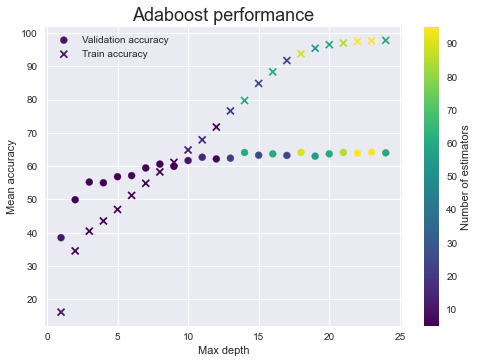

In [140]:
X, X_train, X_val, y, y_train, y_val = get_data()
eval = AdaboostEvaluator("models/model_adaboost_data_summary_stats.pkl")
eval.plot()

In [141]:
print("best validation accuracy: ", max(eval.acc_val))
print("best estimator: ", eval.best_estimator)

best validation accuracy:  64.15203934866646
best estimator:  AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=24),
                  learning_rate=1, n_estimators=60)


### With summary stats and time series cv split

C:\Users\lukas\AppData\Local\Temp\ipykernel_25156\3247544689.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(plot, label = "Number of estimators")


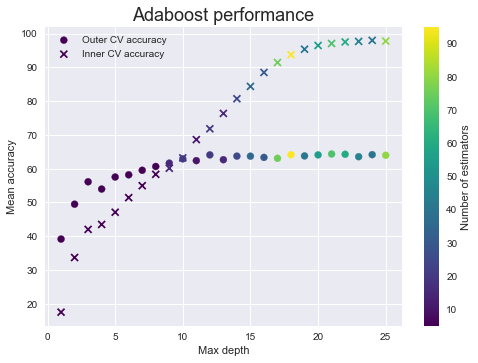

In [276]:
X, X_train, X_val, y, y_train, y_val = get_data()
eval = AdaboostEvaluator("models/model_adaboost_data_summary_stats_tssplit.pkl")
eval.plot()

os.makedirs("plots", exist_ok= True)
plt.savefig("plots/adaboost.pdf")
plt.show()

In [143]:
print("best validation accuracy: ", max(eval.acc_val))
print("best estimator: ", eval.best_estimator)

best validation accuracy:  64.32788935763527
best estimator:  AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=24),
                  learning_rate=1, n_estimators=40)


### With onehot encoding and normal cv split

C:\Users\lukas\AppData\Local\Temp\ipykernel_25156\1830593547.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(plot, label = "Number of estimators")


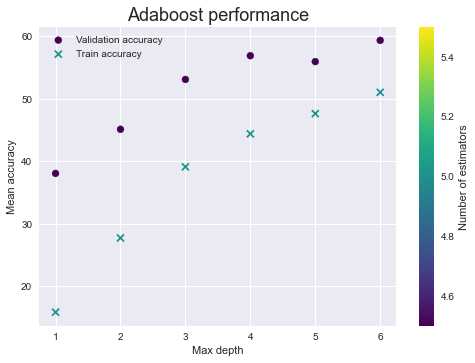

In [144]:
X, X_train, X_val, y, y_train, y_val = get_data(data_format="onehot")
eval = AdaboostEvaluator("models/model_adaboost_data_onehot.pkl")
eval.plot()

In [145]:
print("best validation accuracy: ", max(eval.acc_val))
print("best estimator: ", eval.best_estimator)

best validation accuracy:  59.36881036032654
best estimator:  AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6),
                  learning_rate=1, n_estimators=5)


## Decision trees

### With summary stats and normal cv split

In [118]:
gs = pickle.load( open("models/model_decision_tree_data_summary_stats.pkl", "rb"))
X, X_train, X_val, y, y_train, y_val = get_data(data_format="summary_stats")

In [104]:
gs.cv_results_.keys()
max_depth = gs.cv_results_["param_max_depth"].data
min_samples_leaf = gs.cv_results_["param_min_samples_leaf"].data
gs

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91,
                                       None],
                         'min_samples_leaf': range(1, 200)},
             scoring=make_scorer(accuracy_score, inv_trns=<function <lambda> at 0x0000018B588E4CA0>),
             verbose=2)

C:\Users\lukas\AppData\Local\Temp\ipykernel_25156\3840434663.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(plot, label = "Max depth")


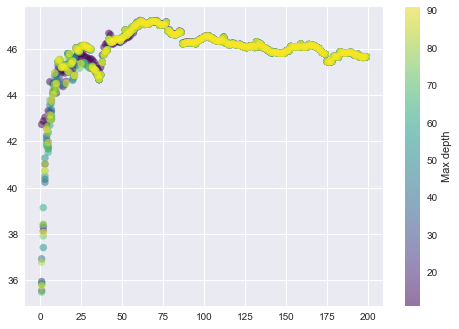

In [111]:
df = pd.DataFrame({
    "max_depth" : max_depth,
    "min_samples_leaf" : min_samples_leaf,
    "acc_train" : gs.cv_results_["mean_test_score"]
})

d = df[df.max_depth != 1]

fig, ax = plt.subplots(1)

plot = ax.scatter(d.min_samples_leaf, d.acc_train, c = d.max_depth, cmap = "viridis", alpha = .5)
fig.colorbar(plot, label = "Max depth")
ax.set_ylabel("Training accuracy")
ax.set_xlabel("Min samples leaf")
ax.set_title("Decision tree performance", fontdict={"size":18})

In [119]:
print("best estimator: ", gs.best_estimator_)
print("best validation accuracy: ", accuracy_score(y_val, gs.best_estimator_.predict(X_val)))

best estimator:  DecisionTreeRegressor(max_depth=11, min_samples_leaf=61)
best validation accuracy:  60.07395823625821


### With summary stats and time series cv split

In [227]:
gs = pickle.load( open("models/model_decision_tree_data_summary_stats_tssplit.pkl", "rb"))
X, X_train, X_val, y, y_train, y_val = get_data(data_format="summary_stats")

In [228]:
gs.cv_results_.keys()
max_depth = gs.cv_results_["param_max_depth"].data
min_samples_leaf = gs.cv_results_["param_min_samples_leaf"].data
gs

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91,
                                       None],
                         'min_samples_leaf': range(1, 200)},
             scoring=make_scorer(accuracy_score, inv_trns=<function <lambda> at 0x0000018B586451F0>),
             verbose=2)

C:\Users\lukas\AppData\Local\Temp\ipykernel_25156\1754046452.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(plot, label = "Max depth")


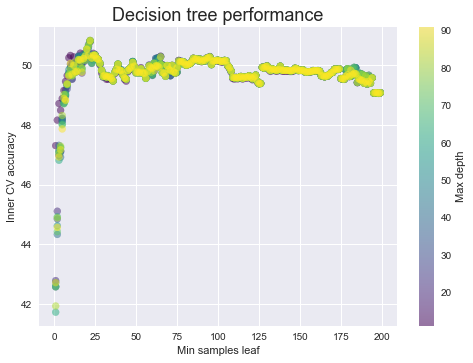

In [231]:
df = pd.DataFrame({
    "max_depth" : max_depth,
    "min_samples_leaf" : min_samples_leaf,
    "acc_train" : gs.cv_results_["mean_test_score"]
})

d = df[df.max_depth != 1]

fig, ax = plt.subplots(1)

plot = ax.scatter(d.min_samples_leaf, d.acc_train, c = d.max_depth, cmap = "viridis", alpha = .5)
fig.colorbar(plot, label = "Max depth")
ax.set_ylabel("Inner CV accuracy")
ax.set_xlabel("Min samples leaf")
ax.set_title("Decision tree performance", fontdict={"size":18})

os.makedirs("plots", exist_ok=True)
plt.savefig("plots/decision_tree.pdf")
plt.show()

In [134]:
print("best estimator: ", gs.best_estimator_)
print("best validation accuracy: ", accuracy_score(y_val, gs.best_estimator_.predict(X_val)))

best estimator:  DecisionTreeRegressor(max_depth=71, min_samples_leaf=22)
best validation accuracy:  60.54182157641602


In [136]:
from itertools import product
params = list(product(gs.param_grid["max_depth"], gs.param_grid["min_samples_leaf"]))
len(params)

2189

### With onehot encoding and normal cv split

In [128]:
gs = pickle.load( open("models/model_decision_tree_data_onehot.pkl", "rb"))
X, X_train, X_val, y, y_train, y_val = get_data(data_format="onehot")

In [125]:
gs.cv_results_.keys()
max_depth = gs.cv_results_["param_max_depth"].data
min_samples_leaf = gs.cv_results_["param_min_samples_leaf"].data
gs

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91,
                                       None],
                         'min_samples_leaf': range(1, 200)},
             scoring=make_scorer(accuracy_score, inv_trns=<function <lambda> at 0x0000018B51931700>),
             verbose=2)

C:\Users\lukas\AppData\Local\Temp\ipykernel_25156\3180945319.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(plot, label = "Max depth")


Text(0.5, 1.0, 'Decision tree performance')

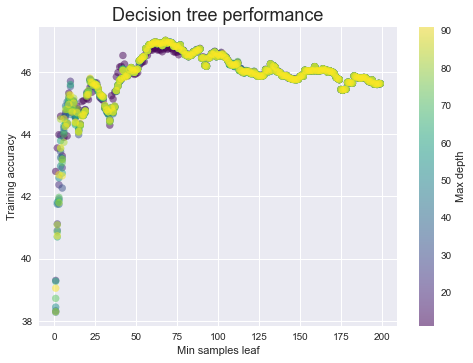

In [126]:
df = pd.DataFrame({
    "max_depth" : max_depth,
    "min_samples_leaf" : min_samples_leaf,
    "acc_train" : gs.cv_results_["mean_test_score"]
})

d = df[df.max_depth != 1]

fig, ax = plt.subplots(1)

plot = ax.scatter(d.min_samples_leaf, d.acc_train, c = d.max_depth, cmap = "viridis", alpha = .5)
fig.colorbar(plot, label = "Max depth")
ax.set_ylabel("Inner CV accuracy")
ax.set_xlabel("Min samples leaf")
ax.set_title("Decision tree performance", fontdict={"size":18})

In [129]:
print("best estimator: ", gs.best_estimator_)
print("best validation accuracy: ", accuracy_score(y_val, gs.best_estimator_.predict(X_val)))

best estimator:  DecisionTreeRegressor(max_depth=21, min_samples_leaf=68)
best validation accuracy:  59.982625196546586
